# Linear regression with micro:bit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Convert milligravities to m/s2
MG_TO_MS2 = 0.00980665

def process_data(data):
    # Clean the columns
    orig_columns = ["time (source1)", "accel_x", "accel_y", "accel_z"]
    new_columns = ["t", "ax", "ay", "az"]
    data = data[orig_columns]
    data.columns = new_columns

    # Clean NaNs
    data = data.dropna()

    # Convert to m/s2
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers with the median
    for acc in ['ax', 'ay', 'az']:
        acc_raw = data[acc].copy()
        acc_raw[np.abs(acc_raw / np.median(acc_raw)) > 1.5] = np.median(acc_raw)
        data[acc] = acc_raw

    # Compute velocity
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial = 0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial = 0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial = 0)

    # Compute position
    data['x'] = cumulative_trapezoid(data['vx'], data['t'], initial = 0)
    data['y'] = cumulative_trapezoid(data['vy'], data['t'], initial = 0)
    data['z'] = cumulative_trapezoid(data['vz'], data['t'], initial = 0)

    return data

1. Read and preprocess the dataset.

In [3]:
data = pd.read_csv("microbit-data-2024-08-02T21-52-40-279Z.csv")
data = process_data(data)
data.head()

,t,ax,ay,az,vx,vy,vz,x,y,z
0,0.000,0.196133,10.591182,0.196133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.050,0.196133,10.591182,0.196133,0.009807,0.529559,0.009807,0.000245,0.013239,0.000245
2,0.084,0.274586,10.669635,0.078453,0.017809,0.890993,0.014475,0.000715,0.037388,0.000658
3,0.100,0.274586,10.669635,0.078453,0.022202,1.061707,0.015730,0.001035,0.053010,0.000900
4,0.110,0.117680,10.591182,0.196133,0.024164,1.168011,0.017103,0.001267,0.064159,0.001064


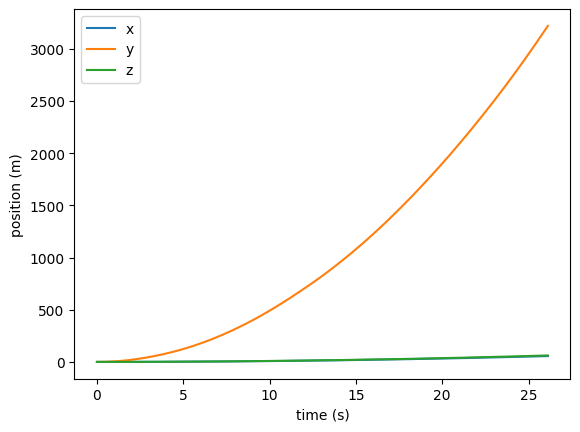

In [6]:
for position in ['x', 'y', 'z']:
    plt.plot(data['t'], data[position], label = position)
plt.xlabel("time (s)")
plt.ylabel("position (m)")
plt.legend()

2. Pick a time period of clean data.

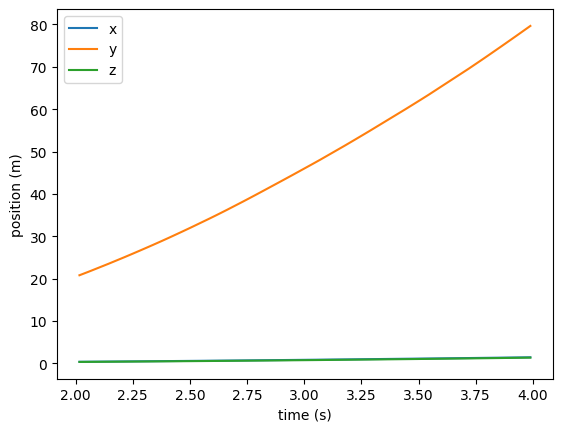

In [11]:
t_start = 2 # seconds
t_end = 4 # seconds

data = data[(data['t'] > t_start) & (data['t'] < t_end)]

for position in ['x', 'y', 'z']:
    plt.plot(data['t'], data[position], label = position)
plt.xlabel("time (s)")
plt.ylabel("position (m)")
plt.legend()

3. Split the data into train and test.

In [12]:
t_threshold = 3 # seconds

all_train = data.loc[data['t'] <= t_threshold]
all_test = data.loc[data['t'] > t_threshold]

X_train, y_train = all_train.loc[:, ["t", "az", "vz"]], all_train.loc[:, "z"]
X_test, y_test = all_test.loc[:, ["t", "az", "vz"]], all_test.loc[:, "z"]

4. Train a linear regression model
$$
\hat{z} = b_0 + b_1 \times t + b_2 \times a_z + b_3 \times v_z
$$

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [14]:
lr.coef_

array([0.2725181 , 0.00324516, 0.88099457])

In [15]:
print("Test MSE: ", mean_squared_error(y_test, preds))
print("Test MAE: ", mean_absolute_error(y_test, preds))

Test MSE:  0.007925148461115732
Test MAE:  0.0733600269290073


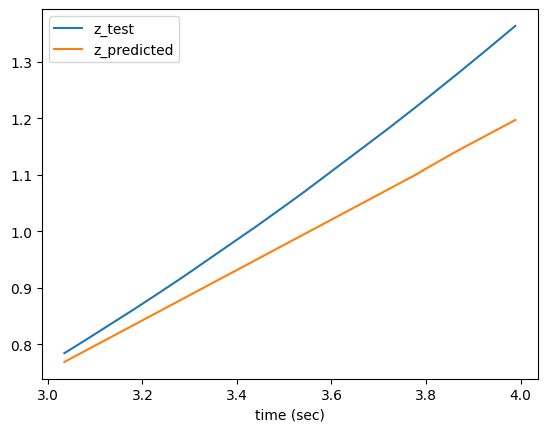

In [16]:
plt.plot(all_test['t'], y_test, label = "z_test")
plt.plot(all_test['t'], preds, label = "z_predicted")
plt.xlabel('time (sec)')
plt.legend()